# Разведывательный анализ данных

В этой работе будет проведен разведывательный анализ набора данных с целью отследить влияние условий жизни учащихся в возрасте от 15 до 22 лет на их успеваемость по математике.

In [424]:
# Load packages and dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

pd.set_option('display.max_rows', 50) # display more rows
pd.set_option('display.max_columns', 50) # display more columns

stud = pd.read_csv('stud_math.csv')

In [425]:
display(stud.head())
stud.info() 

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

## Общее описание данных
Набор данных содержит 395 записей и 30 столбцов, среди них 13 числовых и 17 текстовых переменных. 
Все переменные, по большей части, сожержат ненулевые значения. Также есть переменная *'studytime, granular'*, которой нет в описание данных. Удалим этот столбец.

In [426]:
# Delete studytime, granular column
stud = stud.drop(['studytime, granular'], axis=1)
display(stud.head())

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


## Подготовка целевой переменной

In [427]:
display(pd.DataFrame(stud.score.value_counts(dropna=False)))

,score
50.0,54
55.0,46
0.0,37
75.0,33
65.0,31
40.0,31
60.0,31
45.0,27
70.0,27
80.0,16


Переменная содержит 6 значений NaN. Поскольку в дальнейшем переменная будет использована в качестве целевой переменной при построение модели, отсутствующие значение должны быть удалены.

In [428]:
# Delete entries with NaN score
stud = stud.drop(stud[stud.score.isnull()].index)

## Описательная статистика

### Числовые переменные

In [429]:
stud.describe(include = ['float64', 'int64']) #numerical columns

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
count,389.000000,386.000000,365.000000,361.000000,382.000000,367.000000,362.000000,380.000000,382.000000,374.000000,378.000000,389.000000
mean,16.673522,2.766839,2.627397,1.434903,2.036649,0.326975,3.930939,3.223684,3.094241,3.529412,7.320106,52.262211
std,1.265662,1.094277,2.241790,0.692660,0.847239,0.729479,0.931554,0.993364,1.116104,1.402006,23.615525,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


Таблица описательной статистики для каждой переменной содержит число ненулевых значений, минимум и максимум, среднее, среднеквадратическое отклонение, 1-ый и 3-ий квартили, а также 2-ой квартиль или медиану.

### Категориальные переменные

In [430]:
stud.describe(include = ['object']) #categorical columns

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


В таблице описательной статистики для категориальных переменных отображается количество ненулевых записей, количество уникальных значений в столбце, наиболее частое значение или мода и количество появлений моды.

Как видно из строки 'unique', большинство переменных имеют только две категории. Исключениями являются столбцы *'Mjob'*, *'Fjob'*, *'reason'* и *'guardian'*, которые имеют соответственно 5, 5, 4 и 3 категории. Следовательно, только для этих четырех переменных проверим наличие котегорий с маленьким количеством значений (пороговым значением примем 10).

In [431]:
def small_category(column, tr=10):
    ct = (stud.loc[:, column].value_counts() < tr).sum()
    print("Значений, встретившихся в столбце", column, "менее", tr, "раз:", ct)

In [432]:
cols = ['Mjob', 'Fjob', 'reason', 'guardian']
[small_category(element, 10) for element in cols]

Значений, встретившихся в столбце Mjob менее 10 раз: 0
Значений, встретившихся в столбце Fjob менее 10 раз: 0
Значений, встретившихся в столбце reason менее 10 раз: 0
Значений, встретившихся в столбце guardian менее 10 раз: 0


[None, None, None, None]

Нет категорий с очень маленьким числом упоминаний, следовательно, нет необхлжимости объединять категории.

## Графики ящик с усами

In [433]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=stud.loc[stud.loc[:, column].isin(stud.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [434]:
# Select numerical and categorical columns
num_col = stud.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_col = stud.select_dtypes(exclude=['float64', 'int64']).columns.tolist()

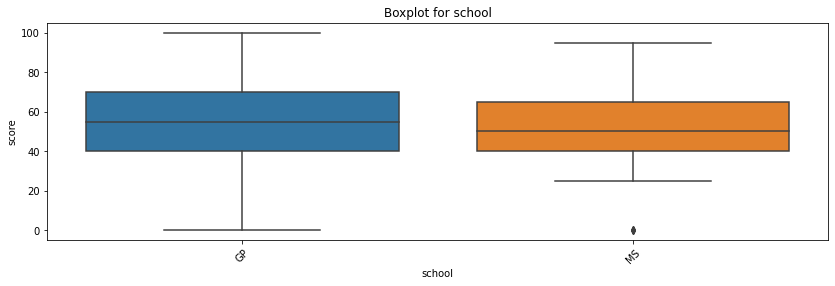

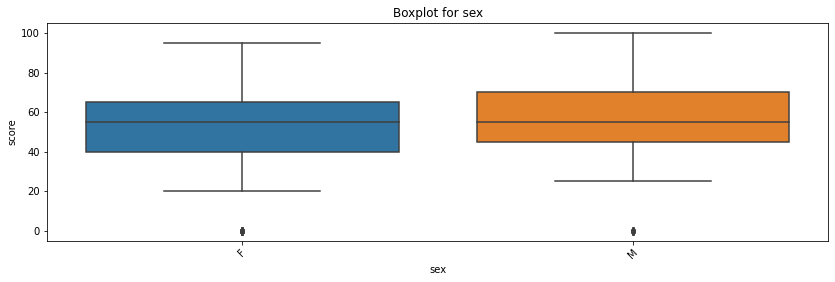

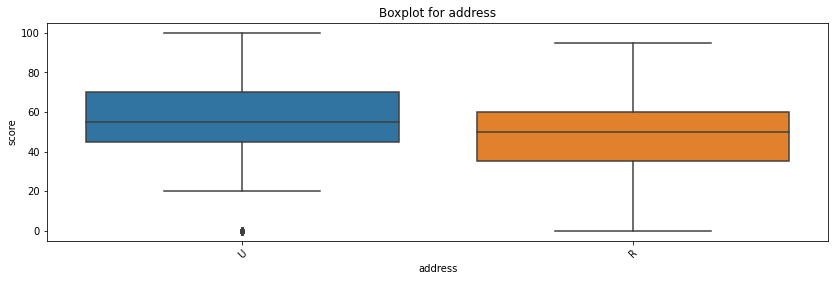

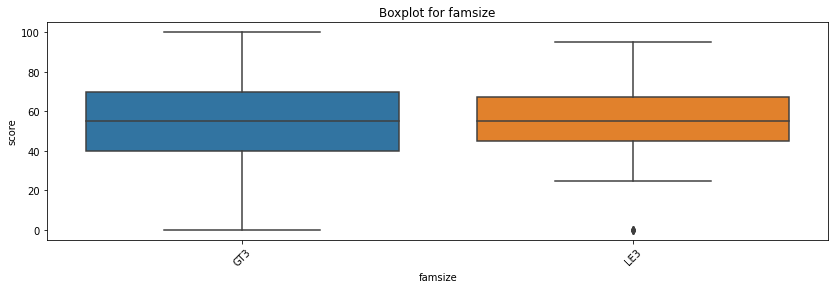

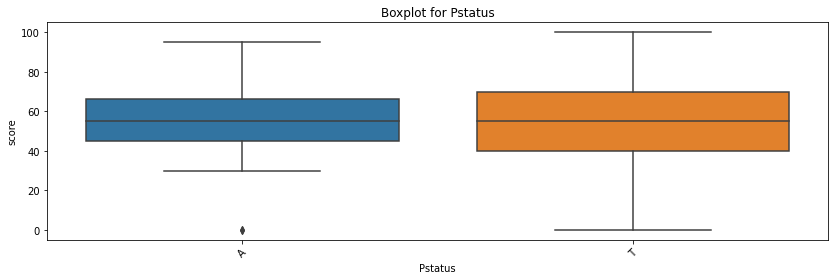

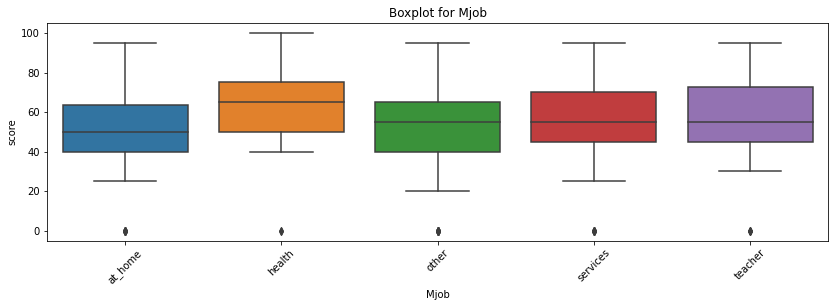

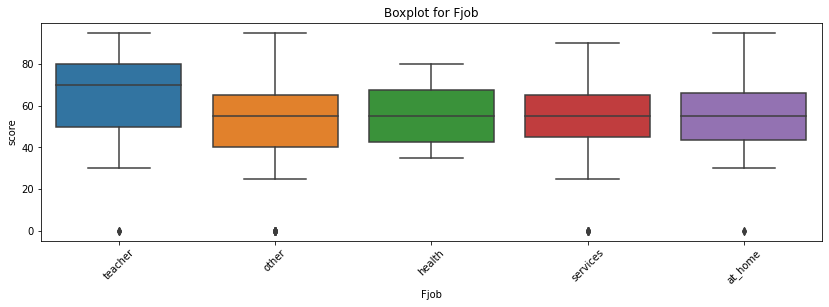

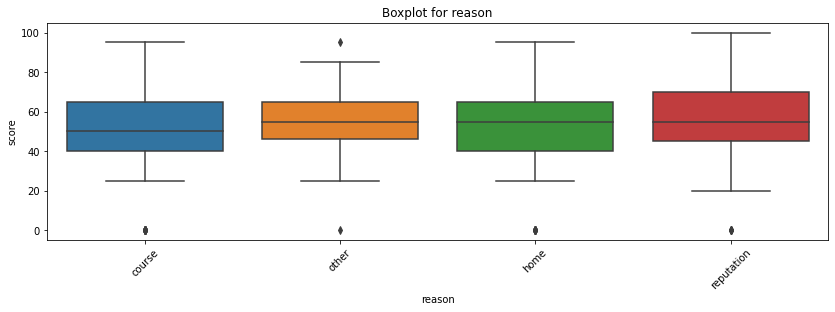

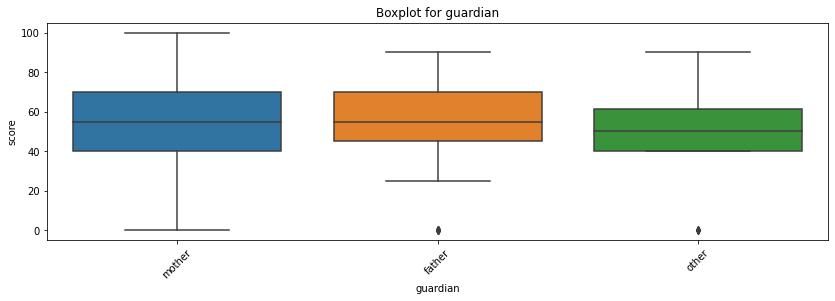

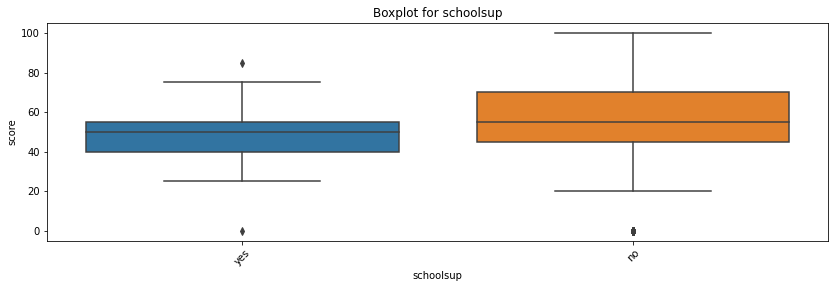

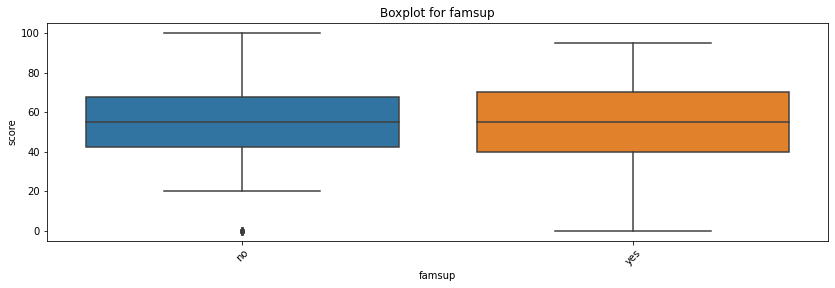

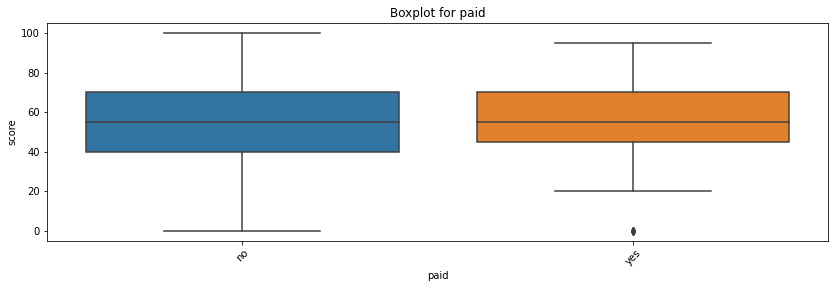

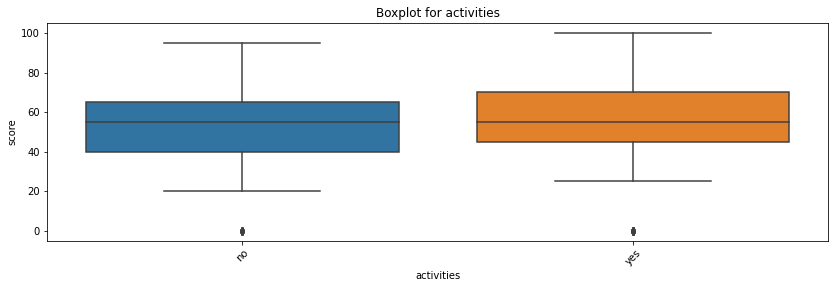

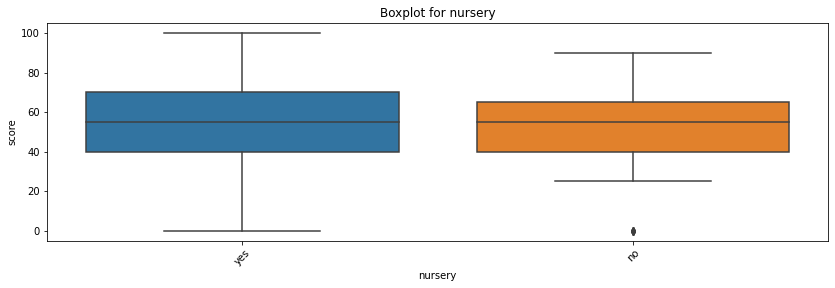

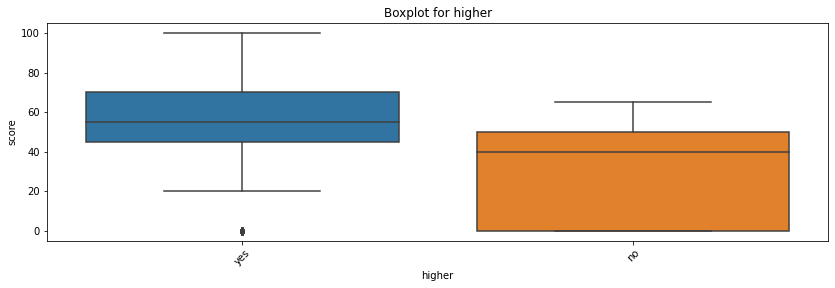

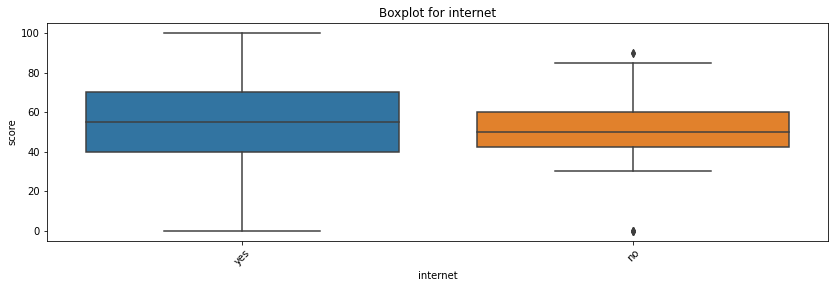

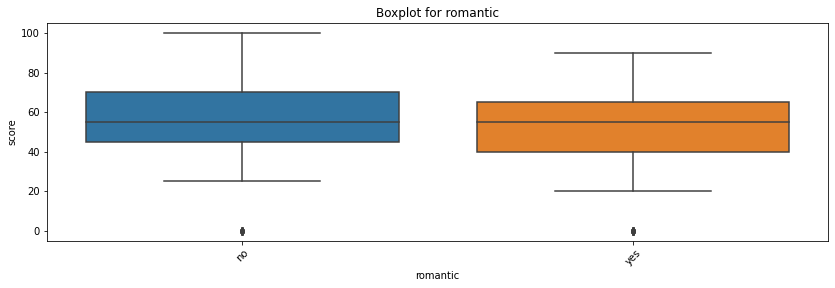

In [435]:
for col in cat_col:
    get_boxplot(col)

### Выводы

Представлены графики "ящик с усами" для всех номинативных переменных относительно баллов за экзамен (score). 

1) Исходя из графиков можно сделать вывод, что все переменные содержат только те значения, которые были указаны в описании набора данных. 

2) Почти у всех переменных разных категориях медианы находятся на одном уровне. Однако формы "ящика" различаются. Так, например, у переменной *'romantic'* медианы визуально практически на одном уровне, но для значений *'no'* распределение скошено в сторону более высоких оценок, а у *'yes'* 1-ый и 3-ий квартили и "усы" меньше значений первой группы. В обеих группах значения score=0 рассматриваются как выбросы.

3) Заметное различие в переменной *'higher'*. Видно, что учащиеся, которые не хотят получить высшее образование сдают экзамен значительно хуже. Можно сделать вывод, что эта переменная будет существенна при моделировании оценок. 


## Однородность выборок

Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам.

С помощью теста t-Стьюдента проверяем гипотезу о равенстве средних значений выборок (однородность в слабом смысле). Гипотеза проверяется с 95% вероятностью (уровнь значимости $\alpha$ = 5%). <br>

$H0: \mu_1 = \mu_2$ <br>
$H1: \mu_1 \neq \mu_2$


In [436]:
def get_stat_dif(column):
    cols = stud.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(stud.loc[stud.loc[:, column] == comb[0], 'score'], 
                        stud.loc[stud.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all): #+ поправка Бонферрони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [437]:
for col in cat_col:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки address
Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки higher
Найдены статистически значимые различия для колонки romantic


### Выводы

Согласно тесту Стьюдента статстически значимые различия есть для четырех переменных. В том числе, как мы и предполагали в выводах к графикам "ящик с усами", баллы для категории переменной *'higher'* значимо различаются. 

## Анализ числовых переменных

### Проверка соответсвия диапазонов значений с указаными в описании 

Переменные проверяются на корректность значений. Некорректные записи удаляются.

In [438]:
# Check correctness of variables (int, object). Return incorrect entries indexes
def var_correctness(column, rng):
    if stud.loc[:, column].dtypes == 'float64':
        indx = stud[~(stud.loc[:, column].between(min(rng), max(rng)) |
                    stud.loc[:, column].isnull())].index
    else:
        indx = stud[~(stud.loc[:, column].isin(rng) |
                    stud.loc[:, column].isnull())].index
    if len(indx) == 0:
        print("Переменная " + column + " корректна")
    else:
        print("Переменная", column, "содержит неверные значения")
    return indx

In [439]:
var_correctness('age', [*range(15, 23)])

Переменная age корректна


Int64Index([], dtype='int64')

In [440]:
cols = ['Medu', 'Fedu', 'traveltime', 'studytime']
indx = [var_correctness(element, [1, 4]) for element in cols]

Переменная Medu содержит неверные значения
Переменная Fedu содержит неверные значения
Переменная traveltime корректна
Переменная studytime корректна


In [441]:
# Change all unampropriate values to NaN
for i in range(0, len(indx)):
    if len(indx[i]) > 0: stud.loc[indx[i], cols[i]] = np.nan

In [442]:
var_correctness('failures', [0, 3])

Переменная failures корректна


Int64Index([], dtype='int64')

In [443]:
cols = ['famrel', 'freetime', 'goout', 'health']
indx = [var_correctness(element, [1, 5]) for element in cols]

Переменная famrel содержит неверные значения
Переменная freetime корректна
Переменная goout корректна
Переменная health корректна


In [444]:
# Change all unampropriate values to NaN
for i in range(0, len(indx)):
    if len(indx[i]) > 0: stud.loc[indx[i], cols[i]] = np.nan

In [445]:
# Check that all values are positive
indx = var_correctness('absences', [0, stud.absences.max()])

Переменная absences корректна


In [446]:
# Check that all values are positive
indx = var_correctness('score', [0, stud.score.max()])

Переменная score корректна


### Анализ числовых переменных 

In [447]:
import warnings; warnings.simplefilter('ignore')    # don't show warning messages

In [448]:
# Function to draw histogram and scatter plot
def hist_scatter(column):
    fig, ax =plt.subplots(1,2, figsize=(10, 4))
    hist = sns.histplot(stud[column], ax=ax[0])
    hist.set_title(column)
    scatt = sns.regplot(x=column, y='score', data=stud, ax=ax[1])
    scatt.set_title('score vs ' + column)
    fig.show()

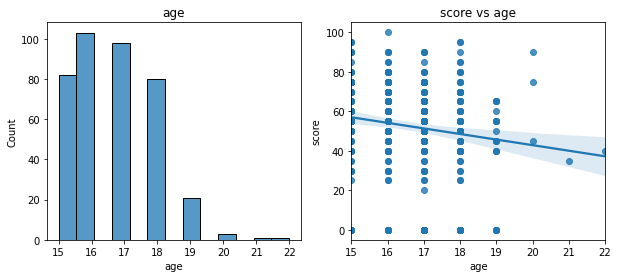

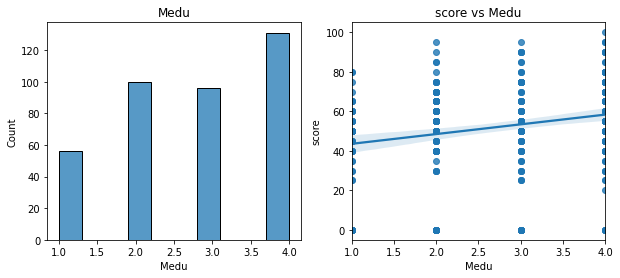

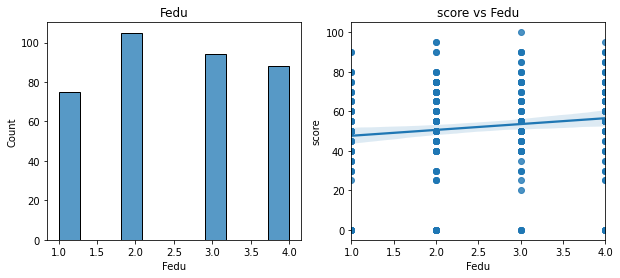

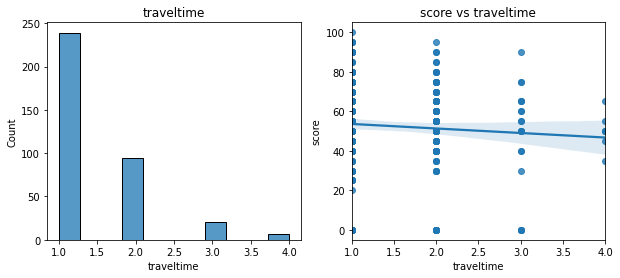

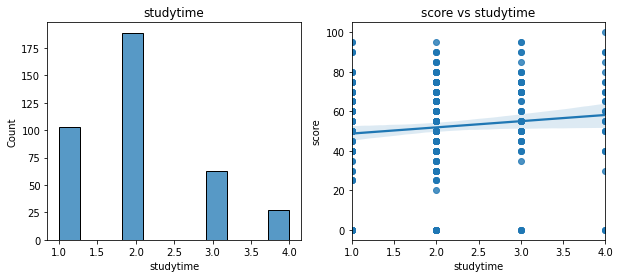

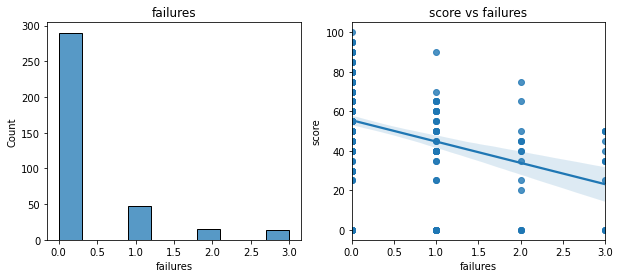

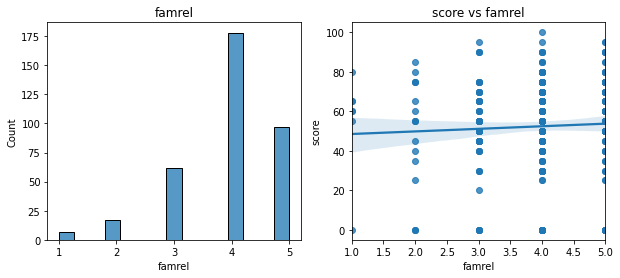

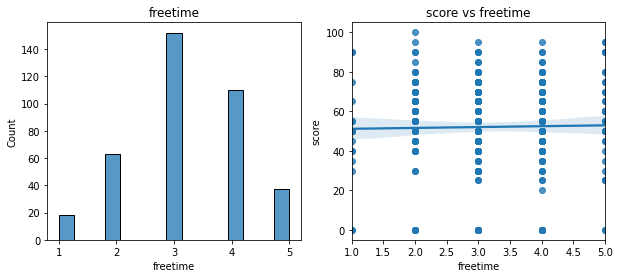

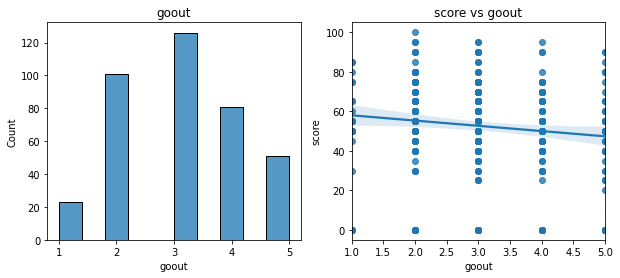

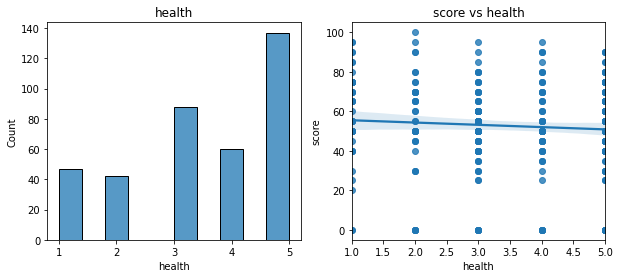

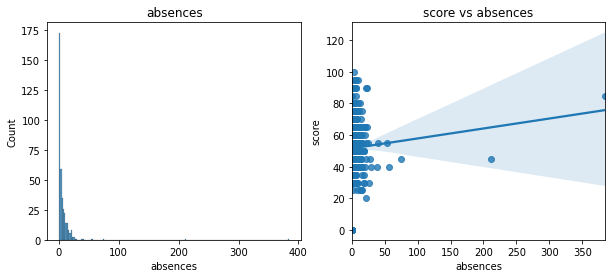

In [449]:
for i in num_col[:-1]:
    hist_scatter(i)

### Выводы

В этом разделе для каждой переменной представлены два графика - гистограмма и диаграмма рассеяния относительно целевой переменной *'score'*. На диаграмме рассеяния также изображена линия регрессии, показывающая уравнение зависимости целевой переменной от рассматриваемого фактора. 

Все числовые переменные являются дискретными, большинство из которых отражают собой определённые категори. Так, например, *'Medu'* показывает уровень образования матери учащегося и может принимать только 4 значения. Поэтому на гистограмме отрображены 4 столбца по позможным значения. Как видно, самый высокий столбец со значением 4, следовательно у большинства учащихся у метерей высшее образование. На графике рассеяния для этой переменной видно, что линия уравнения регрессии  возрастает. Это говорит о том, что чем выше уровень образования матери, тем выше *'score'*. Однако, стоит отметить, что связь слабая, т.к. линия возрастает слабо.

Можно сказать, что большинство переменных практически не влияет на *'score'* - линии регрессии практически параллельны оси Х, линейная связь отсутствует. Это показывает, что увеличение переменной не влечет за собой изменения баллов за экзамен. Единственная переменная, для которой графика рассеяния показывает наличие линейной связи со *'score'* - это *'failures'*. В данном случае присутствует обратный тренд - чем больше неудач, тем хуже баллы за экзамен.

### Корреляционный анализ

Для выявления связи между целевой переменной *'score'* и остальными числовыми переменными необходимо провести корреляционный анализ. 

In [450]:
# Correlation matrix
correlation = stud.corr()
correlation

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.140644,-0.162880,0.073146,-0.018227,0.205919,0.054846,0.016099,0.121115,-0.068103,0.096628,-0.155726
Medu,-0.140644,1.000000,0.638822,-0.174283,0.082520,-0.231585,-0.025577,0.041715,0.060215,-0.042729,-0.020392,0.230728
Fedu,-0.162880,0.638822,1.000000,-0.133613,0.028795,-0.277592,-0.033850,-0.009069,0.048724,0.002923,0.020586,0.139615
traveltime,0.073146,-0.174283,-0.133613,1.000000,-0.105910,0.049738,-0.039304,-0.026299,0.032629,-0.011724,-0.048242,-0.070559
studytime,-0.018227,0.082520,0.028795,-0.105910,1.000000,-0.181947,0.029253,-0.125066,-0.053831,-0.079180,-0.025707,0.115741
failures,0.205919,-0.231585,-0.277592,0.049738,-0.181947,1.000000,0.000506,0.091608,0.107747,0.088013,0.058166,-0.344338
famrel,0.054846,-0.025577,-0.033850,-0.039304,0.029253,0.000506,1.000000,0.162715,0.064314,0.100807,-0.081634,0.051219
freetime,0.016099,0.041715,-0.009069,-0.026299,-0.125066,0.091608,0.162715,1.000000,0.296338,0.064315,0.010745,0.019026
goout,0.121115,0.060215,0.048724,0.032629,-0.053831,0.107747,0.064314,0.296338,1.000000,-0.018026,-0.047954,-0.129685
health,-0.068103,-0.042729,0.002923,-0.011724,-0.079180,0.088013,0.100807,0.064315,-0.018026,1.000000,-0.016165,-0.070460


Text(0.5, 1.0, 'Correlation matrix')

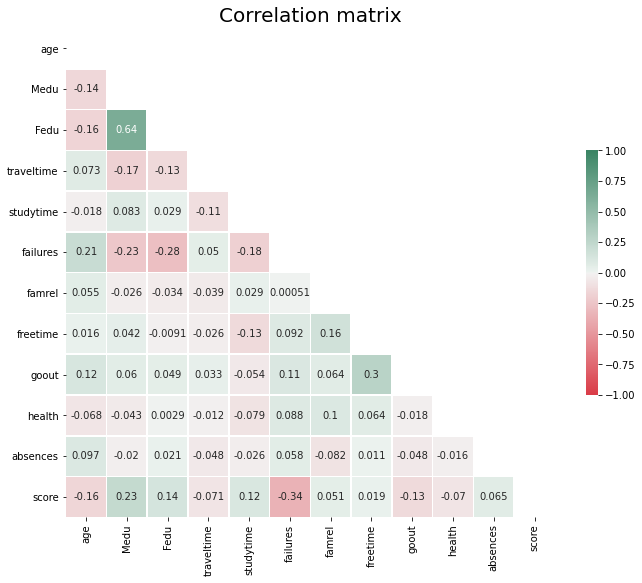

In [451]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(correlation, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))

# Set colormap
cmap = sns.diverging_palette(10, 150, as_cmap=True)

# Draw the heatmap
htmp = sns.heatmap(correlation, mask=mask, annot=True, cmap=cmap, vmin=-1, vmax=1,
            center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
htmp.set_title('Correlation matrix', fontsize=20)

### Выводы

На графике изображен нижний треугольник корреляционной матрицы. Коэффициент корреляции ищменяется от -1 до 1. Отрицательные значения отмечены красным цветом, а положительные зелёным. Чем сильнее связь между переменными, тем насыщенее цвет.

Самый высокий коэффициент корреляции между переменными *'Medu'* и *'Fedu'*, 0.64. Однако, это не очень сильная связь. Самый низкий коэффициент между *'score'* и *'failures'*, -0.34. Эту зависимость мы видели и на графике рассеиния, но связь слабая - абсолютное значение коэффициента низкое.array

Говоря о связи с целевой переменной, то самая сильная она как раз с *'failures'*, все остальные переменные, можно сказать, не влияют на балл за экзамен.

Таким образом в данном наборе можно выделить 5 переменных влияющих на баллы - *'failures'*, *'address'*,*'romantic'*,*'Mjob'* и *'higher'*.

Однако, я бы оставила все переменные для дальнейшего моделирования. 
Во-первых, комбинация переменных может оказаться значимой для моделирования *'score'*.
Во-вторых, корреляция проверяет линейную связь. Возможно для моделирования *'score'* потребуется нелинейная модель.

In [452]:
# Define best variable dataset
stud_for_model = stud.loc[:, ['failures', 'address', 'romantic', 'Mjob', 
                            'higher', 'score']]
stud_for_model.head()

,failures,address,romantic,Mjob,higher,score
0,0.0,U,no,at_home,yes,30.0
1,0.0,U,no,at_home,yes,30.0
2,3.0,U,NaN,at_home,yes,50.0
3,0.0,U,yes,health,yes,75.0
4,0.0,U,no,other,yes,50.0


## Пропущенные значения

Для дальнейшего моделирования необходимо что-то сделать с пропущенными значениями. Один из вариантов - это удалить пропуски. Однако, если пропусков очень много, то можно заменить их на самое ожидаемое значение. В случае строковых и категориальных переменных пропуски можно заменить на моду. Для числовых переменных можно заменить пропуски на среднее или медиану.

Сперва посмотрим, сколько пропущенных значений в каждой переменной.


In [453]:
def missings(column):
    indx = stud[stud.loc[:, column].isnull()].index
    print("Переменная", column, "содержит пропущенных значений: ", len(indx), "или", 
            round(len(indx)/len(stud)*100), "%")
    return indx

In [454]:
indx = [missings(element) for element in stud.columns.tolist()]

Переменная school содержит пропущенных значений:  0 или 0 %
Переменная sex содержит пропущенных значений:  0 или 0 %
Переменная age содержит пропущенных значений:  0 или 0 %
Переменная address содержит пропущенных значений:  15 или 4 %
Переменная famsize содержит пропущенных значений:  27 или 7 %
Переменная Pstatus содержит пропущенных значений:  45 или 12 %
Переменная Medu содержит пропущенных значений:  6 или 2 %
Переменная Fedu содержит пропущенных значений:  27 или 7 %
Переменная Mjob содержит пропущенных значений:  19 или 5 %
Переменная Fjob содержит пропущенных значений:  36 или 9 %
Переменная reason содержит пропущенных значений:  17 или 4 %
Переменная guardian содержит пропущенных значений:  31 или 8 %
Переменная traveltime содержит пропущенных значений:  28 или 7 %
Переменная studytime содержит пропущенных значений:  7 или 2 %
Переменная failures содержит пропущенных значений:  22 или 6 %
Переменная schoolsup содержит пропущенных значений:  9 или 2 %
Переменная famsup содержит

По каждой переменной в отдельности пропущенных значений не более 12%. Однако, необходимо посмотреть сколько строк в совокупности содержат хотя бы одно пропущенное значение.

In [455]:
# List of all entries which contain at least one null value
all_idx = [item for sublist in indx for item in sublist]
all_idx = list(set(all_idx))
len(all_idx) / len(stud)

0.7532133676092545

Если удалять все пропущенные значения, то придётся удалить 75% данных. Это очень много, поэтому я бы предложила перед началом моделирования заменить пропуски. В нашем случае все числовые переменные дискретные, а большинство по сути ранговые. Поэтому, заменим пропуски на моду переменной.  

In [457]:
cols = stud.columns.to_list()
for i in range(0, len(indx)):
    if len(indx[i]) > 0:
        md = stud[cols[i]].mode()
        stud[cols[i]] = stud[cols[i]].fillna(md, inplace=True)